## Amazon Beauty Reviews - Sentiment Analysis

In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk import word_tokenize
from string import punctuation
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, confusion_matrix
from textblob import TextBlob
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import itertools
import seaborn as sns



## Preprocessing 

In [18]:
# read the entire file into a python array
with open('Beauty_5.json', 'rb') as f:
    reviews = f.readlines()

data = [line.decode('utf-8') for line in reviews]
# remove the trailing "\n" from each line
data_clean = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data_clean) + "]"

# now, load it into pandas
beauty = pd.read_json((data_json_str))

In [19]:
beauty.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,7806397051,"[3, 4]",1,Very oily and creamy. Not at all what I expect...,"01 30, 2014",A1YJEY40YUW4SE,Andrea,Don't waste your money,1391040000
1,7806397051,"[1, 1]",3,This palette was a decent price and I was look...,"04 18, 2014",A60XNB876KYML,Jessica H.,OK Palette!,1397779200
2,7806397051,"[0, 1]",4,The texture of this concealer pallet is fantas...,"09 6, 2013",A3G6XNM240RMWA,Karen,great quality,1378425600
3,7806397051,"[2, 2]",2,I really can't tell what exactly this thing is...,"12 8, 2013",A1PQFP6SAJ6D80,Norah,Do not work on my face,1386460800
4,7806397051,"[0, 0]",3,"It was a little smaller than I expected, but t...","10 19, 2013",A38FVHZTNQ271F,Nova Amor,It's okay.,1382140800


In [20]:
#cleaning data...lowercase
beauty['reviewText'] = beauty['reviewText'].str.lower()
beauty.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,7806397051,"[3, 4]",1,very oily and creamy. not at all what i expect...,"01 30, 2014",A1YJEY40YUW4SE,Andrea,Don't waste your money,1391040000
1,7806397051,"[1, 1]",3,this palette was a decent price and i was look...,"04 18, 2014",A60XNB876KYML,Jessica H.,OK Palette!,1397779200
2,7806397051,"[0, 1]",4,the texture of this concealer pallet is fantas...,"09 6, 2013",A3G6XNM240RMWA,Karen,great quality,1378425600
3,7806397051,"[2, 2]",2,i really can't tell what exactly this thing is...,"12 8, 2013",A1PQFP6SAJ6D80,Norah,Do not work on my face,1386460800
4,7806397051,"[0, 0]",3,"it was a little smaller than i expected, but t...","10 19, 2013",A38FVHZTNQ271F,Nova Amor,It's okay.,1382140800


In [21]:
def remove_punctuations(text):
    for punct in punctuation:
        text = text.replace(punct, ' ')
    return text

In [22]:
# remove punctuation
beauty['reviewText'] = beauty['reviewText'].apply(remove_punctuations)

In [23]:
# remove stopwords
stop = stopwords.words('english')
beauty['reviewText'] = beauty['reviewText'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
beauty.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,7806397051,"[3, 4]",1,oily creamy expected ordered try highlight con...,"01 30, 2014",A1YJEY40YUW4SE,Andrea,Don't waste your money,1391040000
1,7806397051,"[1, 1]",3,palette decent price looking different shades ...,"04 18, 2014",A60XNB876KYML,Jessica H.,OK Palette!,1397779200
2,7806397051,"[0, 1]",4,texture concealer pallet fantastic great cover...,"09 6, 2013",A3G6XNM240RMWA,Karen,great quality,1378425600
3,7806397051,"[2, 2]",2,really tell exactly thing powder kind oil ish ...,"12 8, 2013",A1PQFP6SAJ6D80,Norah,Do not work on my face,1386460800
4,7806397051,"[0, 0]",3,little smaller expected okay lasted long time ...,"10 19, 2013",A38FVHZTNQ271F,Nova Amor,It's okay.,1382140800


In [24]:
# creating a tokenized column for the reviewText
beauty['reviewText_tok'] = beauty['reviewText'].apply(word_tokenize)

In [25]:
# creating a positive negative column where positive review (4-5) are 1 and negative reviews (1-3) are 0.
beauty['pos_neg'] = beauty['overall'].apply(lambda x: 1 if x > 3 else 0)

In [26]:
beauty.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,reviewText_tok,pos_neg
0,7806397051,"[3, 4]",1,oily creamy expected ordered try highlight con...,"01 30, 2014",A1YJEY40YUW4SE,Andrea,Don't waste your money,1391040000,"[oily, creamy, expected, ordered, try, highlig...",0
1,7806397051,"[1, 1]",3,palette decent price looking different shades ...,"04 18, 2014",A60XNB876KYML,Jessica H.,OK Palette!,1397779200,"[palette, decent, price, looking, different, s...",0
2,7806397051,"[0, 1]",4,texture concealer pallet fantastic great cover...,"09 6, 2013",A3G6XNM240RMWA,Karen,great quality,1378425600,"[texture, concealer, pallet, fantastic, great,...",1
3,7806397051,"[2, 2]",2,really tell exactly thing powder kind oil ish ...,"12 8, 2013",A1PQFP6SAJ6D80,Norah,Do not work on my face,1386460800,"[really, tell, exactly, thing, powder, kind, o...",0
4,7806397051,"[0, 0]",3,little smaller expected okay lasted long time ...,"10 19, 2013",A38FVHZTNQ271F,Nova Amor,It's okay.,1382140800,"[little, smaller, expected, okay, lasted, long...",0


## EDA

In [27]:
print('Number of overall reviews: ', len(beauty.pos_neg))

Number of overall reviews:  198502


In [28]:
print('Number of positive reviews: ', beauty.pos_neg.sum())
print('Percent of reviews: ', beauty.pos_neg.sum()/len(beauty.pos_neg)*100)

Number of positive reviews:  154272
Percent of reviews:  77.7181086337


In [29]:
print('Number of negative reviews: ', 198502-154272)
print('Percent of reviews: ', 44230/len(beauty.pos_neg)*100)

Number of negative reviews:  44230
Percent of reviews:  22.281891366333838


In [30]:
print('Number of unique reviewers: ', len(set(beauty.reviewerID)))

Number of unique reviewers:  22363


In [31]:
length = []
for review in beauty.reviewText_tok:
    length.append(len(review))
print('Average Length of Reviews: ', np.mean(length))

Average Length of Reviews:  44.1185932635


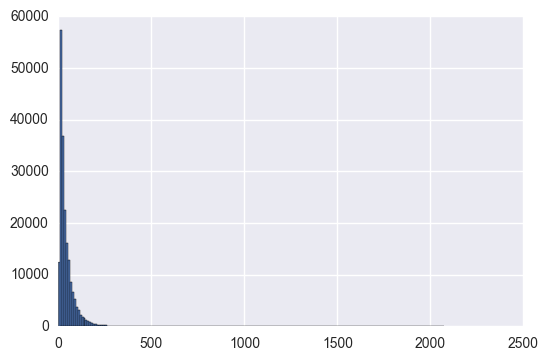

In [32]:
plt.hist(length, bins=200);

In [33]:
max(length)

2073

In [34]:
pos_reviews = beauty[beauty.pos_neg == 1]
#pos_reviews.head()

In [35]:
pos_length = []
for review in pos_reviews.reviewText_tok:
    pos_length.append(len(review))
print('Average Length of Positive Reviews: ', np.mean(pos_length))

Average Length of Positive Reviews:  43.7661079133


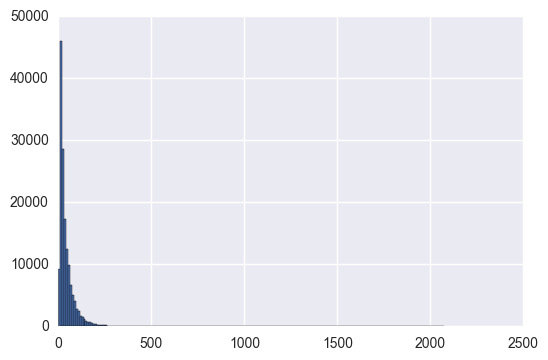

In [36]:
plt.hist(pos_length, bins=200);

In [37]:
neg_reviews = beauty[beauty.pos_neg == 0]
neg_length = []
for review in neg_reviews.reviewText_tok:
    neg_length.append(len(review))
print('Average Length of Negative Reviews: ', np.mean(length))

Average Length of Negative Reviews:  44.1185932635


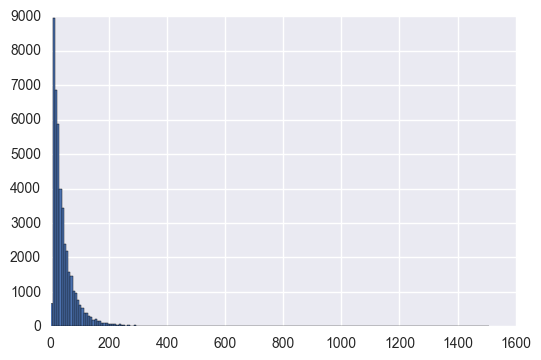

In [38]:
plt.hist(neg_length, bins=200);

## Naive Bayes

In [39]:
train_x, test_x, train_y, test_y = train_test_split(beauty.reviewText, beauty.pos_neg, random_state=42)

In [40]:
print('Size of training set: ', len(train_x))
print('Size of test set: ', len(test_x))

Size of training set:  148876
Size of test set:  49626


In [41]:
CV = CountVectorizer()
x_train_CV = CV.fit_transform(train_x)
x_test_CV = CV.transform(test_x)

In [42]:
svd = TruncatedSVD()
svd.fit(x_train_CV)

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)

In [43]:
NB_CV = MultinomialNB(alpha=1.6)
NB_CV.fit(x_train_CV, train_y)

MultinomialNB(alpha=1.6, class_prior=None, fit_prior=True)

In [44]:
tfidf = TfidfVectorizer()
x_train_tf = tfidf.fit_transform(train_x)
x_test_tf = tfidf.transform(test_x)

In [45]:
svd = TruncatedSVD()
svd.fit(x_train_tf) 

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)

** In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).**

In [46]:
NB_tf = MultinomialNB(alpha=0.01)
NB_tf.fit(x_train_tf, train_y)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [47]:
f1_tf = f1_score(test_y, NB_tf.predict(x_test_tf))
f1_tf

0.88833033271762263

In [48]:
f1_CV = f1_score(test_y, NB_CV.predict(x_test_CV))
f1_CV

0.90572957969865187

** Count Vectorization out performed tf-idf(term frequency inverse document frequency). I looked at the f1-scores since there is a class imbalance. **

In [49]:
#code source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 5470  5631]
 [ 1977 36548]]


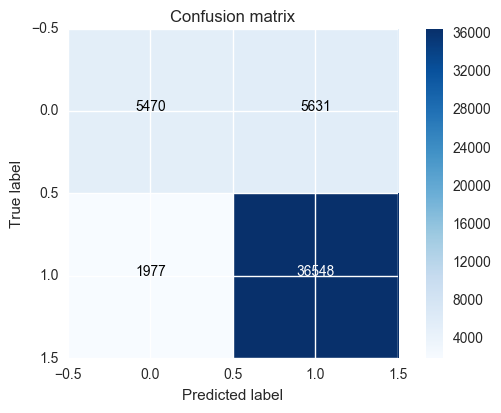

In [50]:
cm1 = confusion_matrix(test_y, NB_CV.predict(x_test_CV))
plot_confusion_matrix(cm1);

Confusion matrix, without normalization
[[ 2081  9020]
 [  532 37993]]


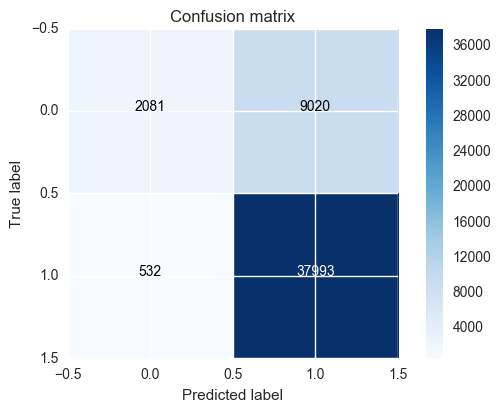

In [51]:
cm2 = confusion_matrix(test_y, NB_tf.predict(x_test_tf))
plot_confusion_matrix(cm2);

## Logistic Regression

In [52]:
lg = LogisticRegression()
lg.fit_transform(x_train_tf, train_y)

/Users/aubreybrowne/anaconda/envs/nlp/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


<148876x17757 sparse matrix of type '<class 'numpy.float64'>'
	with 4725242 stored elements in Compressed Sparse Column format>

In [53]:
tf_lg = lg.score(x_test_tf, test_y)
tf_lg

0.86817394107927293

Confusion matrix, without normalization
[[ 6321  4780]
 [ 1762 36763]]


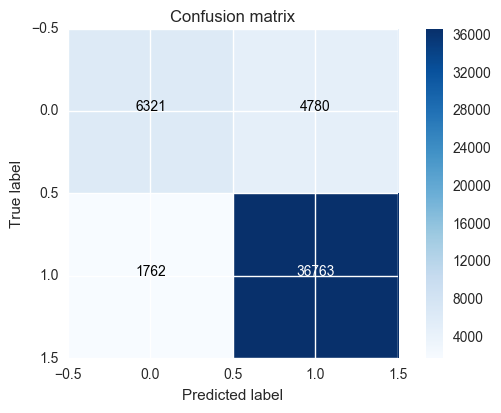

In [54]:
cm_lg = confusion_matrix(test_y, lg.predict(x_test_tf))
plot_confusion_matrix(cm_lg);

In [55]:
lg_cv = LogisticRegression()
lg_cv.fit_transform(x_train_CV, train_y)

/Users/aubreybrowne/anaconda/envs/nlp/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


<148876x22996 sparse matrix of type '<class 'numpy.int64'>'
	with 2405936 stored elements in Compressed Sparse Column format>

In [56]:
lg_cv.score(x_test_CV, test_y)

0.86087937774553658

Confusion matrix, without normalization
[[ 6498  4603]
 [ 2301 36224]]


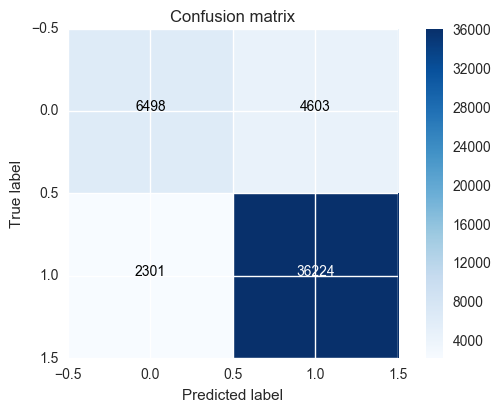

In [57]:
cm_lg_cv = confusion_matrix(test_y, lg_cv.predict(x_test_CV))
plot_confusion_matrix(cm_lg_cv);

## Support Vector Machines

In [ ]:
truncated SVD
svd = TruncatedSVD()
svd.fit(x_train_tf) 

In [58]:
SVM = svm.SVC(kernel='linear')
SVM.fit(x_train_tf, train_y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [59]:
tf_svm = SVM.score(x_test_tf, test_y)

In [60]:
tf_svm

0.8700076572764277

In [61]:
cm_svm = confusion_matrix(test_y, SVM.predict(x_test_tf))

Confusion matrix, without normalization
[[ 6522  4579]
 [ 1872 36653]]


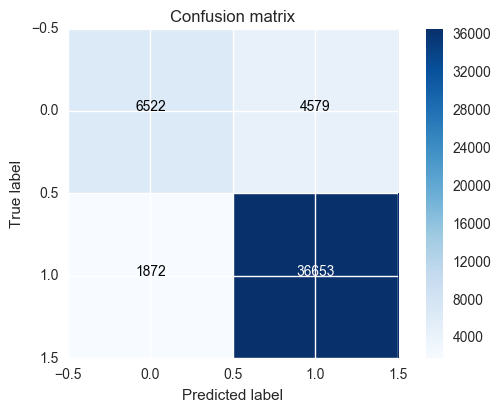

In [62]:
plot_confusion_matrix(cm_svm);

## Multinomial Naive Bayes

In [63]:
# run sentiment analysis by product
x_train, x_test, y_train, y_test = train_test_split(beauty.reviewText, beauty.overall, random_state=42)

In [64]:
CV = CountVectorizer()
X_train_CV = CV.fit_transform(x_train)
X_test_CV = CV.transform(x_test)

In [65]:
NB_CV = MultinomialNB(alpha=0.8)
NB_CV.fit(X_train_CV, y_train)

MultinomialNB(alpha=0.8, class_prior=None, fit_prior=True)

In [66]:
tfidf = TfidfVectorizer()
X_train_tf = tfidf.fit_transform(x_train)
X_test_tf = tfidf.transform(x_test)

In [67]:
NB_tf = MultinomialNB(alpha=0.01)
NB_tf.fit(X_train_tf, y_train)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

In [68]:

f1_tf = f1_score(y_test, NB_tf.predict(X_test_tf), average='micro')
f1_tf

0.59767057590779027

In [69]:
f1_CV = f1_score(y_test, NB_CV.predict(X_test_CV), average='micro')
f1_CV

0.62991173981380733

Confusion matrix, without normalization
[[ 1057   210   344   211   844]
 [  320   226   698   560  1083]
 [  200   132  1349  1743  2124]
 [  112    51   640  3781  5331]
 [  232    97   368  3066 24847]]


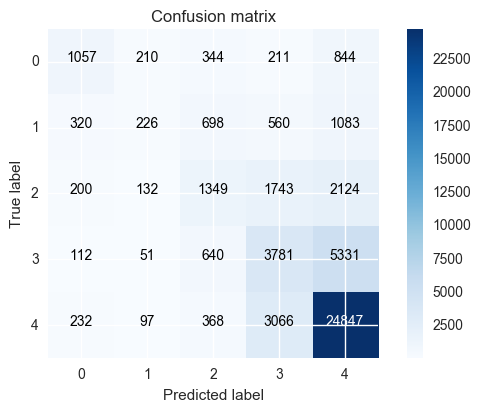

In [70]:
cm_mnb_cv = confusion_matrix(y_test, NB_CV.predict(X_test_CV))
plot_confusion_matrix(cm_mnb_cv);

Confusion matrix, without normalization
[[  426    56   100   108  1976]
 [   87    67   143   270  2320]
 [   49    22   296   673  4508]
 [   32    21   138  1173  8551]
 [   36    20   112   744 27698]]


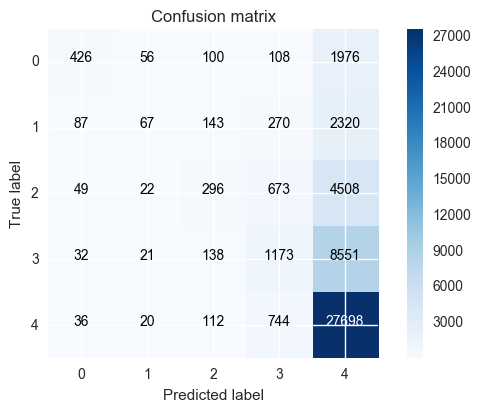

In [71]:
cm_mnb_tf = confusion_matrix(y_test, NB_tf.predict(X_test_tf))
plot_confusion_matrix(cm_mnb_tf);

** It appears that count vectorization actually worked better then tf-idf. **